In [1]:
import pandas as pd
import numpy as np
# Demographics like age, gender, and account details of our clients.
final_demo = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
# A list revealing which clients were part of the grand experiment
df_final_experiment_clients = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
# A detailed trace of client interactions online, divided into two parts: 
# pt_1 and pt_2. It's recommended to merge these two files prior to a comprehensive data analysis.
df_final_web_data_pt_1 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
df_final_web_data_pt_2 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')
# pt1 and pt2 are combined
combined = pd.concat([df_final_web_data_pt_1,df_final_web_data_pt_1], ignore_index=True)


In [2]:
# drop dublicates
datasets = [final_demo, df_final_experiment_clients, combined]
datasets = [df.drop_duplicates() for df in datasets]

In [3]:
# #inconistent:  0   client_id  70609 non-null  int64 
#                  1   Variation  50500 non-null  object - NaN values. Clearify what with it
df_final_experiment_clients.head()


,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [4]:

final_demo.head()
# Who are the primary clients using this online process? - Test group
final_demo_clean = final_demo.copy()
final_demo_clean['gender'] = final_demo_clean['gendr'].replace(['U', 'X', 'NaN'], 'U')

# final_demo[['client_id', 'clnt_age', 'gendr']] 

median_age = final_demo_clean['clnt_age'].median()
median_tenure_year = final_demo_clean['clnt_tenure_yr'].median()
median_tenure_month = final_demo_clean['clnt_tenure_mnth'].median()
final_demo_clean['tenure_years'] = final_demo_clean['clnt_tenure_yr'].apply(lambda x: 'new-standing' if x<median_tenure_year else 'long-standing')
final_demo_clean['tenure_month'] = final_demo_clean['clnt_tenure_mnth'].apply(lambda x: 'new-standing' if x<median_tenure_month else 'long-standing')
final_demo_clean['age_group'] = final_demo_clean['clnt_age'].apply(lambda x: 'younger' if x<median_age else 'older')

clients_age_tenure = final_demo_clean[['client_id', 'gender', 'age_group', 'tenure_years', 'tenure_month']]
test_group = df_final_experiment_clients[df_final_experiment_clients['Variation'] == 'Test']
merged_clients = pd.merge(clients_age_tenure, test_group, on='client_id', how='inner')
merged_clients.head()



,client_id,gender,age_group,tenure_years,tenure_month,Variation
0,836976,U,older,new-standing,new-standing,Test
1,1439522,U,younger,new-standing,new-standing,Test
2,1562045,M,older,long-standing,long-standing,Test
3,388801,M,older,long-standing,long-standing,Test
4,8198645,F,older,long-standing,long-standing,Test


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- load (skip if already in memory) ---
try:
    final_demo
    exp
    web1
    web2
except NameError:
    final_demo = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
    exp = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
    web1 = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
    web2 = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')

# --- combine web correctly (pt1 + pt2) ---
web = pd.concat([web1, web2], ignore_index=True)
web = web[['client_id','visitor_id','visit_id','process_step','date_time']].drop_duplicates()
web['date_time'] = pd.to_datetime(web['date_time'], errors='coerce')

# process step ordering
step_order = {"initial":0, "step_1":1, "step_2":2, "step_3":3, "confirm":4}
web['step_num'] = web['process_step'].map(step_order)

# --- clean demo ---
demo = final_demo.copy()
demo['gender'] = demo['gendr'].replace({'X':'U'}).fillna('U')  # collapse to U
age_med   = demo['clnt_age'].median()
tenure_y_med = demo['clnt_tenure_yr'].median()

demo['age_group']   = np.where(demo['clnt_age'] < age_med, 'younger', 'older')
demo['tenure_group'] = np.where(demo['clnt_tenure_yr'] < tenure_y_med, 'new-standing', 'long-standing')
demo = demo[['client_id','gender','clnt_age','clnt_tenure_yr','bal','num_accts',
             'calls_6_mnth','logons_6_mnth','age_group','tenure_group']].drop_duplicates()

# --- attach experiment variation ---
if 'Variation' in exp.columns and 'variation' not in exp.columns:
    exp = exp.rename(columns={'Variation':'variation'})
exp = exp[['client_id','variation']].drop_duplicates()

# active users (any web activity)
active = (web[['client_id']].drop_duplicates()
          .merge(demo, on='client_id', how='left')
          .merge(exp, on='client_id', how='left'))


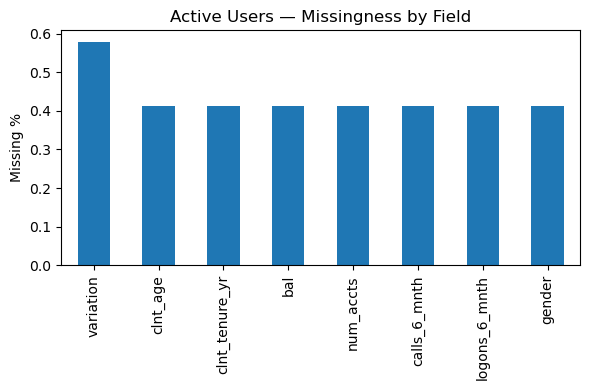

In [6]:
core_cols = ['gender','clnt_age','clnt_tenure_yr','bal','num_accts',
             'calls_6_mnth','logons_6_mnth','variation']
miss = active[core_cols].isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
miss.plot(kind='bar')
plt.ylabel('Missing %')
plt.title('Active Users — Missingness by Field')
plt.tight_layout(); plt.show()


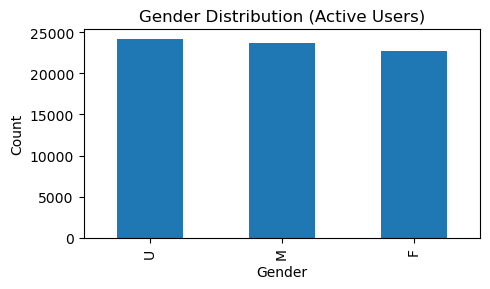

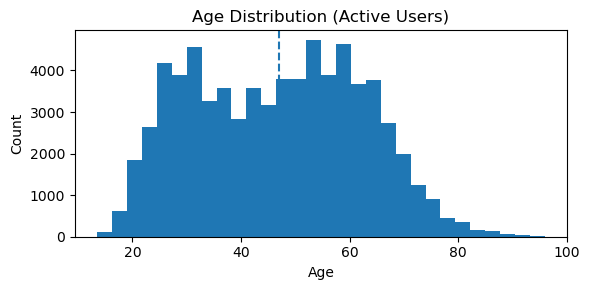

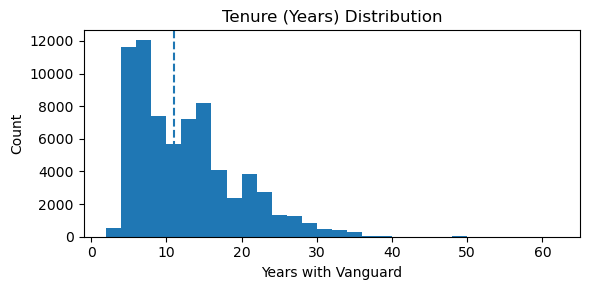

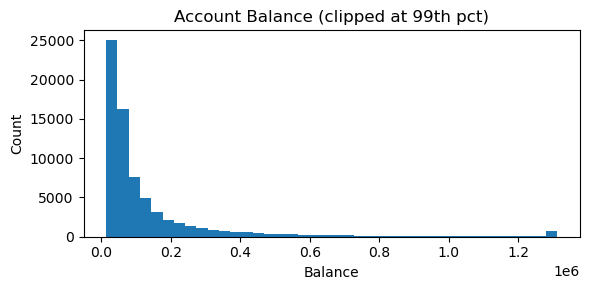

In [7]:
# Gender
g = active['gender'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(5,3))
g.plot(kind='bar')
plt.title('Gender Distribution (Active Users)')
plt.ylabel('Count'); plt.xlabel('Gender')
plt.tight_layout(); plt.show()

# Age
plt.figure(figsize=(6,3))
active['clnt_age'].dropna().plot(kind='hist', bins=30)
plt.axvline(active['clnt_age'].median(), linestyle='--')
plt.title('Age Distribution (Active Users)')
plt.xlabel('Age'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

# Tenure (years)
plt.figure(figsize=(6,3))
active['clnt_tenure_yr'].dropna().plot(kind='hist', bins=30)
plt.axvline(active['clnt_tenure_yr'].median(), linestyle='--')
plt.title('Tenure (Years) Distribution')
plt.xlabel('Years with Vanguard'); plt.ylabel('Count')
plt.tight_layout(); plt.show()

# Balance (clip long tail for readability)
bal = active['bal'].clip(upper=active['bal'].quantile(0.99))
plt.figure(figsize=(6,3))
bal.dropna().plot(kind='hist', bins=40)
plt.title('Account Balance (clipped at 99th pct)')
plt.xlabel('Balance'); plt.ylabel('Count')
plt.tight_layout(); plt.show()


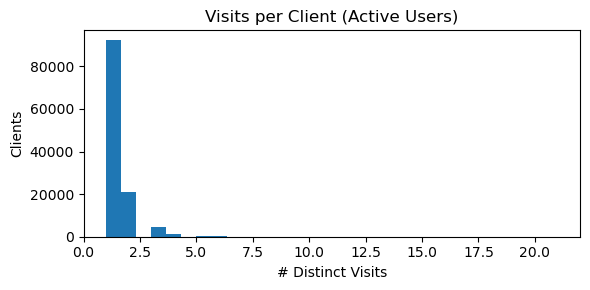

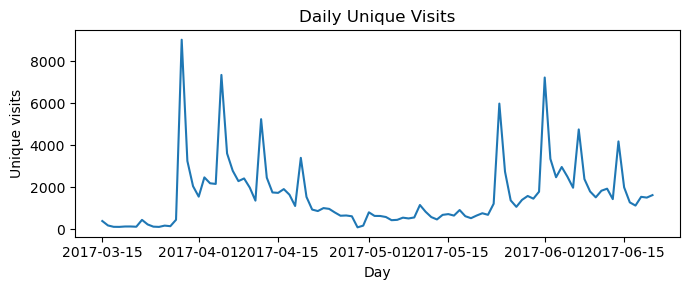

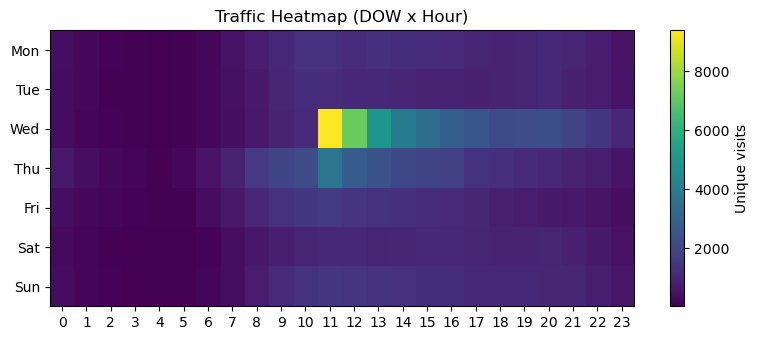

In [8]:
# Visits per client
if 'visit_id' in web.columns:
    visits_per_client = (web.groupby('client_id')['visit_id'].nunique()
                           .sort_values(ascending=False))
    plt.figure(figsize=(6,3))
    visits_per_client.plot(kind='hist', bins=30)
    plt.title('Visits per Client (Active Users)')
    plt.xlabel('# Distinct Visits'); plt.ylabel('Clients')
    plt.tight_layout(); plt.show()

# Activity over time (daily visits)
daily = (web.dropna(subset=['date_time'])
           .assign(day=lambda d: d['date_time'].dt.date)
           .groupby('day')['visit_id'].nunique())
plt.figure(figsize=(7,3))
daily.plot()
plt.title('Daily Unique Visits'); plt.xlabel('Day'); plt.ylabel('Unique visits')
plt.tight_layout(); plt.show()

# Day-of-week & hour-of-day heat map
w = web.dropna(subset=['date_time']).copy()
w['dow'] = w['date_time'].dt.dayofweek  # 0=Mon
w['hr']  = w['date_time'].dt.hour
heat = w.pivot_table(index='dow', columns='hr', values='visit_id',
                     aggfunc='nunique', fill_value=0)
plt.figure(figsize=(8,3.5))
plt.imshow(heat, aspect='auto')
plt.colorbar(label='Unique visits')
plt.yticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(range(24), range(24))
plt.title('Traffic Heatmap (DOW x Hour)')
plt.tight_layout(); plt.show()


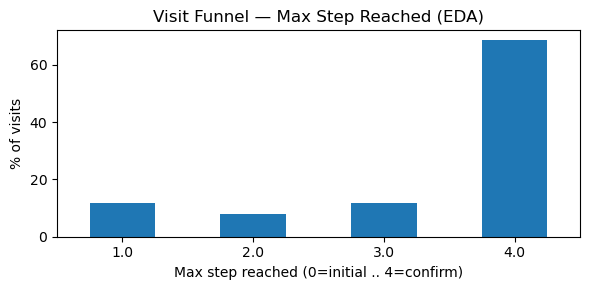

In [9]:
# Max step reached per visit
w_sorted = web.sort_values(['client_id','visit_id','step_num','date_time'])
vis = (w_sorted.groupby(['client_id','visit_id'], as_index=False)
               .agg(max_step=('step_num','max')))

step_counts = vis['max_step'].value_counts().sort_index()
plt.figure(figsize=(6,3))
(step_counts / step_counts.sum() * 100).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('% of visits'); plt.xlabel('Max step reached (0=initial .. 4=confirm)')
plt.title('Visit Funnel — Max Step Reached (EDA)')
plt.tight_layout(); plt.show()


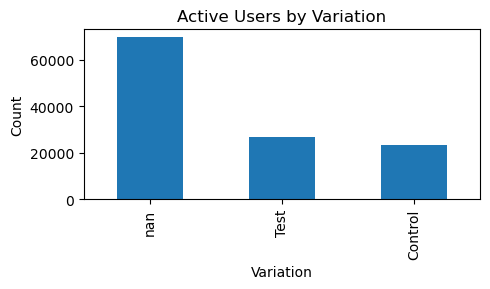

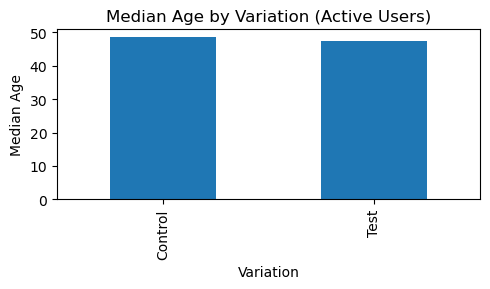

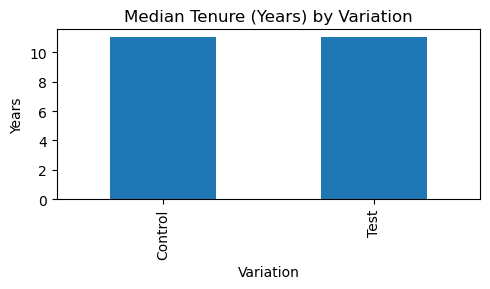

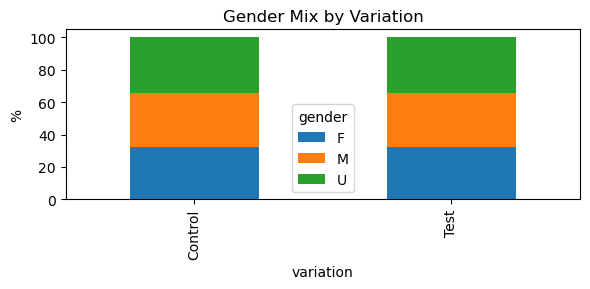

In [10]:
# Variation share among active users
var_share = active['variation'].value_counts(dropna=False)
plt.figure(figsize=(5,3))
var_share.plot(kind='bar')
plt.title('Active Users by Variation')
plt.ylabel('Count'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Age by variation (median bars)
summary_age = (active.groupby('variation')['clnt_age']
                     .median()
                     .sort_values(ascending=False))
plt.figure(figsize=(5,3))
summary_age.plot(kind='bar')
plt.title('Median Age by Variation (Active Users)')
plt.ylabel('Median Age'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Tenure by variation (median)
summary_tenure = active.groupby('variation')['clnt_tenure_yr'].median()
plt.figure(figsize=(5,3))
summary_tenure.plot(kind='bar')
plt.title('Median Tenure (Years) by Variation')
plt.ylabel('Years'); plt.xlabel('Variation')
plt.tight_layout(); plt.show()

# Gender composition by variation (stacked %)
gender_var = (active.pivot_table(index='variation', columns='gender',
                                 values='client_id', aggfunc='nunique', fill_value=0))
gender_pct = gender_var.div(gender_var.sum(axis=1), axis=0) * 100
ax = gender_pct.plot(kind='bar', stacked=True, figsize=(6,3))
ax.set_ylabel('%'); ax.set_title('Gender Mix by Variation')
plt.tight_layout(); plt.show()
